In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
from tqdm import tqdm

import numpy as np

sys.path.append(os.environ['DH_DIR'])
from config import load_data
from main import get_elec_cooling_data
from   darkhistory.spec.spectrum import Spectrum
import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
from   darkhistory.electrons import positronium as pos
from   darkhistory.electrons.elec_cooling import get_elec_cooling_tf
from   darkhistory.spec import pppc

from darkhistory.low_energy.lowE_electrons import make_interpolator
from darkhistory.low_energy.lowE_deposition import compute_fs
from low_energy.lowE_electrons import make_interpolator as my_make_interpolator
from low_energy.lowE_deposition import compute_fs as my_compute_fs
from utils import load_dict

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

## Config

In [3]:
run_name = '230629'
tf_type = 'phot' # {'phot', 'elec'}
include_f_xray = True
xray_eng_range = (1e2, 1e4) # [eV]
use_tqdm = True
verbose = 0 # {0, 1}
stop_after_n = np.inf

abscs = load_dict(f"../data/abscissas/abscs_{run_name}.h5")
inj_abscs = abscs['photE'] if tf_type == 'phot' else abscs['elecEk'] + phys.me
MEDEA_dir = '../data/MEDEA'
data_dir = f'../data/tf/{run_name}/{tf_type}'
save_dir = f'../data/tf/{run_name}/{tf_type}'
os.makedirs(save_dir, exist_ok=True)

In [4]:
abscs['dep_c']

array(['H ion', 'He ion', 'exc', 'heat', 'cont', 'xray'], dtype=object)

## Load

In [4]:
os.listdir(data_dir)

['lep_tf_rxneo.npy',
 'phot_dep.h5',
 'lowerbound_rxneo.npy',
 'phot_depgv.npy',
 'hed_tf_rxneo.npy',
 'cmbloss_rxneo.npy',
 'phot_tfgv.npy',
 'phot_phot.h5',
 'phot_scat.h5',
 'hep_tf_rxneo.npy',
 'phot_prop.h5',
 '.ipynb_checkpoints',
 'ionhist_output',
 'phot_prop_diag.h5',
 'lee_tf_rxneo.npy']

In [10]:
print('Loading tf: ', end=' ', flush=True)
hep_tfgv = np.load(f'{data_dir}/hep_tf_rxneo.npy')
print('hep', end=' ', flush=True)
lep_tfgv = np.load(f'{data_dir}/lep_tf_rxneo.npy')
print('lep', end=' ', flush=True)
lee_tfgv = np.load(f'{data_dir}/lee_tf_rxneo.npy')
print('lee', end=' ', flush=True)
hed_tfgv = np.load(f'{data_dir}/hed_tf_rxneo.npy')
print('hed', end=' ', flush=True)
cmbloss_gv = np.load(f'{data_dir}/cmbloss_rxneo.npy')
print('cmb', end='.', flush=True)

Loading tf:  hep lep lee hed cmb.

## uhm

In [129]:
in_spec_phot = pppc.get_pppc_spec(photeng[300], photeng, 'phot_delta', 'phot')
print(np.where(in_spec_phot.N), in_spec_phot.N[299])

(array([299]),) 2.1603348648263028


## Loop over `rs` `x` `nBs` NEW!!

In [11]:
i_rs = 8
i_x = 2
i_nBs = 6
rs = abscs['rs'][i_rs]
x = abscs['x'][i_x]
nBs = abscs['nBs'][i_nBs]
print(rs, x, nBs)

dlnz = abscs['dlnz']
dt = dlnz / phys.hubble(rs)

i_Ein = 300

38.71318413405634 0.001 1.006


In [12]:
hep_tf = hep_tfgv[i_rs, i_x, i_nBs].copy()
lep_tf = lep_tfgv[i_rs, i_x, i_nBs].copy()
lee_tf = lee_tfgv[i_rs, i_x, i_nBs].copy()
hed_tf = hed_tfgv[i_rs, i_x, i_nBs].copy()

# process hep_tf
cmb_un = spectools.discretize(abscs['photE'], phys.CMB_spec, phys.TCMB(rs))
cmb_un_E = cmb_un.toteng()
cmb_E = cmbloss_gv[i_rs, i_x, i_nBs, i_Ein] * dt
hep_tf[i_Ein] += (-cmb_E/cmb_un_E) * cmb_un.N

# process lep_tf
for i in range(len(abscs['photE'])):
    if lep_tf[i][i] > 1e-40:
        break
    lep_tf[i][i] = 1

In [15]:
norm_fac(rs)

2300596905829076.5

In [14]:
photeng = abscs['photE']
eleceng = abscs['elecEk']

in_spec_phot_N = np.zeros((500,))
in_spec_phot_N[300] = 1.
in_spec_phot = Spectrum(photeng, in_spec_phot_N, spec_type='N', rs=rs)

struct_boost = lambda x: 1.
rate_func_N = lambda x: 1.
rate_func_eng = lambda x: photeng[i_Ein]

start_rs = rs
dt = dlnz * 1 / phys.hubble(rs)

def norm_fac(rs):
    # Normalization to convert from per injection event to 
    # per baryon per dlnz step. 
    return rate_func_N(rs) * (
        dlnz * 1 / phys.hubble(rs) / (phys.nB * rs**3)
    )

def rate_func_eng_unclustered(rs):
    return rate_func_eng(rs)

highengdep_grid = np.empty((0,4))

MEDEA_interp = make_interpolator(interp_type='2D', cross_check=False)
    
highengphot_spec_at_rs = Spectrum(photeng, hep_tf[i_Ein], spec_type='N', rs=rs) * norm_fac(rs)
lowengphot_spec_at_rs  = Spectrum(photeng, lep_tf[i_Ein], spec_type='N', rs=rs) * norm_fac(rs)
lowengelec_spec_at_rs  = Spectrum(eleceng, lee_tf[i_Ein], spec_type='N', rs=rs) * norm_fac(rs)
highengdep_at_rs       = hed_tf[i_Ein] * norm_fac(rs)


highengphot_spec_at_rs += in_spec_phot * norm_fac(rs)
highengphot_spec_at_rs.rs = rs

x_vec_for_f = np.array([1-x, phys.chi*(1-x), x])

print('lep E', lowengelec_spec_at_rs.toteng()/highengphot_spec_at_rs.toteng())
print('lee E', lowengphot_spec_at_rs.toteng()/highengphot_spec_at_rs.toteng())
print('x    ', x_vec_for_f)
print('rateu', rate_func_eng_unclustered(rs))
print('dlnz ', dlnz)
print('hubbl', phys.hubble(rs))
print('dt   ', f'{dt:.3e}')
print('hed  ', highengdep_at_rs*dt/highengphot_spec_at_rs.toteng())


f_raw = compute_fs(
    MEDEA_interp, lowengelec_spec_at_rs, lowengphot_spec_at_rs,
    x_vec_for_f, rate_func_eng_unclustered(rs), dt,
    highengdep_at_rs, method='no_He', cross_check=False
)
fs = np.sum(f_raw, axis=0)
print('fs   ', fs) # H ion, He ion, exc, heat, cont

lep E 4.763673821012494e-05
lee E 0.0
x     [0.999     0.0810447 0.001    ]
rateu 1158962.0723298236
dlnz  0.009950330853168092
hubbl 2.9673038390402664e-16
dt    3.353e+13
hed   [ 2.12807794e-05  1.67609907e-05  5.84832912e-07 -1.03879246e-07]
fs    [6.65252694e-05 1.04326618e-06 5.65002650e-05 3.82248125e-05
 1.00113427e-05]


In [32]:
from main import evolve

In [151]:
soln = evolve(
    DM_process='swave', mDM=photeng[i_Ein+1], sigmav=1e-20, primary='phot_delta',
    start_rs=rs, end_rs=rs/1.001**2,
    coarsen_factor=1, backreaction=True, 
    struct_boost=lambda rs: 1.,
    init_cond=[x, x, 10],
    reion_switch=False,
    compute_fs_method='He',
#     photoion_rate_func = [lambda rs: 0.] * 3,
#     photoheat_rate_func = [lambda rs: 0.] * 3,
#     xe_reion_func = lambda rs: xe,
    use_tqdm=False, verbose=1
)

Loading time: 0.000 s
Initialization time: 0.003 s
lep E 0.0
lee E 0.0
x     [0.999      0.08012583 0.001     ]
rateu 4.2993000138112975e-11
dlnz  0.001
hubbl 2.9673038390402664e-16
dt    3.370e+12
hed   [0. 0. 0. 0.]
lep E 4.777348001673408e-06
lee E 0.0
x     [9.99000002e-01 8.11258278e-02 5.43939893e-14]
rateu 4.273581446585765e-11
dlnz  0.001
hubbl 2.962841982615395e-16
dt    3.375e+12
hed   [ 2.17399974e-06  1.71442982e-06  1.05873113e-07 -1.08326370e-08]
Main loop time: 0.092 s


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


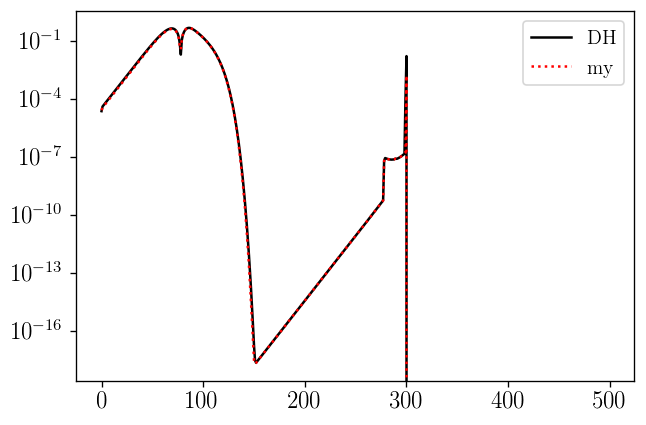

In [156]:
plt.plot(np.abs(soln['highengphot'][1].N), color='k', label='DH')
plt.plot(np.abs(highengphot_spec_at_rs.N * np.max(soln['highengphot'][1].N) / np.max(highengphot_spec_at_rs.N)), ls=':', color='r', label='my')
plt.yscale('log')
plt.legend();

In [132]:
dh_fs = np.array([soln['f']['low'][k][1] + soln['f']['low'][k][1] for k in soln['f']['low']])

In [133]:
dh_fs

array([4.80989826e-06, 2.09484231e-07, 4.61139089e-06, 7.43298680e-06,
       2.05055326e-06])

In [190]:
old_fs = np.array([6.65252694e-05, 1.04326618e-06, 5.65002650e-05, 3.82248125e-05,1.00113427e-05])
old_fs = [6.65252694e-05 1.04326618e-06 5.65002650e-05 3.82248125e-05
 1.00113427e-05]

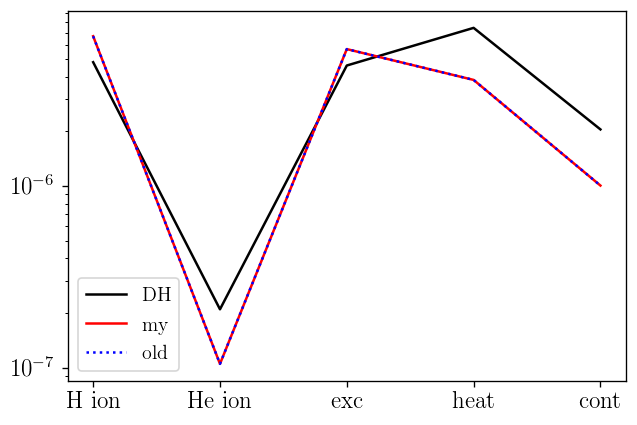

In [192]:
fig, ax = plt.subplots()
ax.plot(dh_fs, color='k', label='DH')
ax.plot(fs/(dlnz/0.001), color='r', label='my')
ax.plot(old_fs/(dlnz/0.001), color='blue', label='old', ls=':')
ax.set_yscale('log')
ax.legend()
ax.set_xticks(np.arange(5))
ax.set_xticklabels(['H ion', 'He ion', 'exc', 'heat', 'cont']);

In [159]:
dh_fs/(fs/(dlnz/0.001))

array([0.71942706, 1.99799192, 0.8121177 , 1.93488661, 2.03805664])

## Loop over `rs` `x` `nBs`

In [8]:
print('Loading tf: ', end=' ', flush=True)
hep_tfgv = np.load(f'{data_dir}/hep_tf_rxneo.npy')
print('hep', end=' ', flush=True)
lep_tfgv = np.load(f'{data_dir}/lep_tf_rxneo.npy')
print('lep', end=' ', flush=True)
lee_tfgv = np.load(f'{data_dir}/lee_tf_rxneo.npy')
print('lee', end=' ', flush=True)
hed_tfgv = np.load(f'{data_dir}/hed_tf_rxneo.npy')
print('hed', end=' ', flush=True)
cmbloss_gv = np.load(f'{data_dir}/cmbloss_rxneo.npy')
print('cmb', end='.', flush=True)

Loading tf:  hep lep lee hed cmb.

In [6]:
use_tqdm = False

In [9]:
# tfgv = np.zeros_like(hep_tfgv) # in: elec/phot, out: phot
# depgv = np.zeros(
#     hed_tfgv.shape[:-1] + (len(abscs['dep_c']),)
# ) # channels: {H ionization, He ionization, excitation, heat, continuum, xray}

dlnz = abscs['dlnz']
MEDEA_interp = my_make_interpolator(prefix=MEDEA_dir)

n_run = -1

if use_tqdm:
    pbar = tqdm( total = len(abscs['rs'])*len(abscs['x'])*len(abscs['nBs']) )

for i_rs, rs in enumerate(abscs['rs']):
    
    if i_rs != 8:# TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP
        continue
    
    dt = dlnz / phys.hubble(rs)
            
    #==============================
    # Add cmbloss to highengphot
    cmb_un = spectools.discretize(abscs['photE'], phys.CMB_spec, phys.TCMB(rs))
    cmb_un_E = cmb_un.toteng()
    
    for i_x, x in enumerate(abscs['x']):
        
        if i_x != 2:# TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP
            continue
        for i_nBs, nBs in enumerate(abscs['nBs']):
            
            if i_nBs != 6:# TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP
                continue
            
            for i in range(len(inj_abscs)):
                cmb_E = cmbloss_gv[i_rs, i_x, i_nBs][i] * dt
                hep_tfgv[i_rs, i_x, i_nBs][i] += (-cmb_E/cmb_un_E) * cmb_un.N

            #==============================
            # Add lowengphot diagonal
            if nBs == 0: # lowengphot is 0 when nBs is 0
                raise NotImplementedError
            if tf_type == 'phot':
                for i in range(len(inj_abscs)):
                    if lep_tfgv[i_rs, i_x, i_nBs][i][i] > 1e-40:
                        break
                    lep_tfgv[i_rs, i_x, i_nBs][i][i] = 1
            
            for i_injE, injE in enumerate(inj_abscs):
                
                if i_injE != 300:# TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP TMP
                    continue
                
                assert n_run <= stop_after_n
                n_run += 1

                #==============================
                # Injection
                # inject one photon at i_injE
                timer = time.time()
                
                hep_spec_N = hep_tfgv[i_rs, i_x, i_nBs, i_injE]
                lep_spec_N = lep_tfgv[i_rs, i_x, i_nBs, i_injE]
                lee_spec_N = lee_tfgv[i_rs, i_x, i_nBs, i_injE]
                hed_arr    = hed_tfgv[i_rs, i_x, i_nBs, i_injE]

                lowengelec_spec_at_rs = Spectrum(abscs['elecEk'], lee_spec_N, spec_type='N')
                lowengelec_spec_at_rs.rs = rs

                lowengphot_spec_at_rs = Spectrum(abscs['photE'], lep_spec_N, spec_type='N')
                lowengphot_spec_at_rs.rs = rs

                highengdep_at_rs = hed_arr

                #==============================
                # Compute f's
                x_vec_for_f = np.array( [1-x, phys.chi*(1-x), x] ) # [HI, HeI, HeII]/nH
                nBs_ref = 1
                dE_dVdt_inj = injE * phys.nB * nBs_ref * rs**3 / dt # [eV/cm^3 s]
                # in DH.main: (dN_inj/dB) / (dE_inj  /dVdt)
                # here:       (dN_inj   ) / (dE_injdB/dVdt)
                
                print('lep E', lowengelec_spec_at_rs.toteng()/np.dot(inj_abscs, hep_spec_N))
                print('lee E', lowengphot_spec_at_rs.toteng()/np.dot(inj_abscs, hep_spec_N))
                print('x    ', x_vec_for_f)
                #print('rateu', rate_func_eng_unclustered(rs))
                print('dlnz ', dlnz)
                print('hubbl', phys.hubble(rs))
                print('dt   ', f'{dt:.3e}')
                print('hed  ', highengdep_at_rs*dt/np.dot(inj_abscs, hep_spec_N))
                
                f_low, f_high = my_compute_fs(
                    MEDEA_interp=MEDEA_interp,
                    rs=rs,
                    x=x_vec_for_f,
                    elec_spec=lowengelec_spec_at_rs,
                    phot_spec=lowengphot_spec_at_rs,
                    dE_dVdt_inj=dE_dVdt_inj,
                    dt=dt,
                    highengdep=highengdep_at_rs,
                    cmbloss=0, # turned off in darkhistory main as well
                    method='no_He',
                    cross_check=False,
                    ion_old=False
                )
                f_raw = f_low + f_high
                
                print(f_raw)
                
                raise RuntimeError

                #==============================
                # Compute tf & f values
                lep_prop_spec_N = lep_spec_N * (abscs['photE'] < 10.2)
                f_lep_prop = np.dot(abscs['photE'], lep_prop_spec_N) / injE
                phot_spec_N = hep_spec_N + lep_prop_spec_N
                f_prop = np.dot(abscs['photE'], phot_spec_N) / injE

                f_dep = f_raw
                f_dep[4] -= f_lep_prop # adjust for the propagating lowengphot
                f_tot = f_prop + np.sum(f_dep)

                #==============================
                # Fix energy conservation (known issues)
                if tf_type == 'phot':
                    if i_injE == 153: # issue at around 13.6 eV. Adjusting H_ion.
                        f_dep[0] += 1 - f_tot
                    if i_injE in range(224, 228): # ??? issue. Adjusting hep propagating bin.
                        phot_spec_N[i_injE] += 1 - f_tot

                f_prop = np.dot(abscs['photE'], phot_spec_N) / injE
                f_tot = f_prop + np.sum(f_dep)

                #==============================
                # Energy conservation
                f_dep_str = ' '.join([f'{v:.3e}' for v in f_dep])
                print_str = f'{n_run} | {i_rs} {i_x} {i_nBs} {i_injE} | f_prop={f_prop:.6f} f_dep={f_dep_str} f_tot={f_tot:.6f}'
                if np.abs(f_tot - 1.) > 1e-2:
                    print_str += ' | Energy error > 1%'
                if verbose >= 1 or np.abs(f_tot - 1.) > 1e-2:
                    print(print_str, flush=True)
                
                phot_spec_N[i_injE] += 1 - f_tot # gives all extra energy to propagating photons
                
                #==============================
                # Dependent variables (Xray)
                if include_f_xray:
                    i_xray_fm = np.searchsorted(abscs['photE'], xray_eng_range[0])
                    i_xray_to = np.searchsorted(abscs['photE'], xray_eng_range[1])
                    f_xray = np.dot(abscs['photE'][i_xray_fm:i_xray_to], phot_spec_N[i_xray_fm:i_xray_to]) / injE
                    if i_xray_fm <= i_injE and i_injE < i_xray_to:
                        f_xray -= phot_spec_N[i_injE] # ignore diagonal for now # NEED TO EXTRACT PROP
                    f_dep = np.append(f_dep, f_xray)

                #==============================
                # Populate transfer functions
                tfgv[i_rs, i_x, i_nBs, i_injE] = phot_spec_N
                depgv[i_rs, i_x, i_nBs, i_injE] = f_dep
            
            if use_tqdm:
                pbar.update()

lep E 9.528120052257906e-05
lee E 0.0
x     [0.999     0.0810447 0.001    ]
dlnz  0.009950330853168092
hubbl 2.9673038390402664e-16
dt    3.353e+13
hed   [ 4.25650094e-05  3.35246991e-05  1.16976065e-06 -2.07775335e-07]
[6.65252694e-05 1.04326618e-06 5.65002650e-05 3.82248125e-05
 1.00113427e-05]


RuntimeError: 

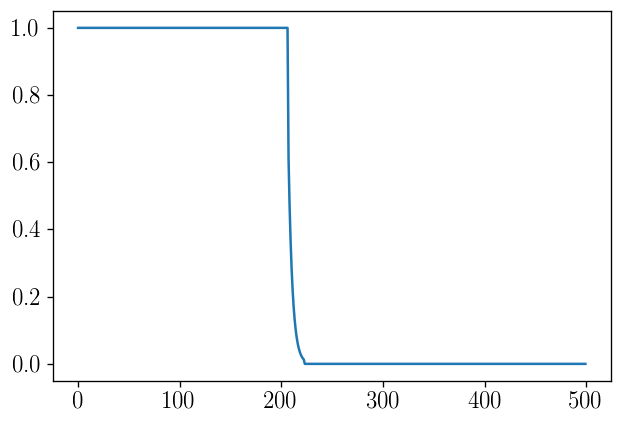

In [189]:
plt.plot(np.diag(lep_tfgv[i_rs, i_x, i_nBs]))

## Save

In [8]:
np.save(f'{save_dir}/{tf_type}_tfgv.npy', tfgv)
np.save(f'{save_dir}/{tf_type}_depgv.npy', depgv)